<b>Author:</b> ...

<b>Contributors:</b> ...


<div class="alert alert-block alert-info">
Before you start running this notebook, make sure you are using the Hail Genomics Analysis Environment. To do so,
<br/>
    
<ul>
    <li>Click on the <b>cloud analysis environment</b> icon on the righthand side of the screen.</li>
    <li>Inside <b>Recommended environments</b>, select <b>Hail Genomics Analysis</b> which creates a cloud environment for your analyses.</li>
    <li>This analysis can be run with <b>low compute</b> (e.g. 2 workers with 4 CPUs, 15 GB of RAM).</li>
    <li>Click on <b>Next</b>.</li>
</ul>
    
</div>

<h1>Notebook Objectives</h1>

This notebook shows where the BAM files and manifest are, how to localize the manifest or a known BAM to your workspace bucket and active environment, and how to use the manifest to localize BAMs by the included paths.

<b>How to Use this Notebook...</b>

<b>As a tutorial:</b>

...

<b>As a resource:</b>

...

<h2>Relevant Information:</h2>

...

In [1]:
import os
import pandas as pd
from google.cloud import bigquery

In [2]:
!gsutil -u $GOOGLE_PROJECT ls gs://fc-aou-datasets-controlled/pooled/longreads/v7_base/bam/ | xargs -n1 basename > lr_sample_ids.txt

In [3]:
if not os.path.exists("genomic_metrics.tsv"):
    !gsutil -u $GOOGLE_PROJECT cp gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/qc/genomic_metrics.tsv .
    
sr_metrics = pd.read_table('genomic_metrics.tsv')

In [4]:
sr_metrics

,research_id,sample_source,site_id,sex_at_birth,dragen_sex_ploidy,mean_coverage,genome_coverage,aou_hdr_coverage,dragen_contamination,aligned_q30_bases,verify_bam_id2_contamination,biosample_collection_date
0,1000004,Whole Blood,bi,M,XY,44.15,96.95,99.67,0.0,1.494380e+11,1.019330e-05,2019-07-26
1,1000033,Whole Blood,bi,M,XY,37.45,96.49,99.46,0.0,1.227449e+11,1.076750e-05,2019-08-06
2,1000039,Whole Blood,bi,F,XX,35.60,95.61,99.51,0.0,1.158729e+11,2.242160e-05,2020-02-11
3,1000042,Whole Blood,bi,M,XY,41.71,96.72,99.37,0.0,1.329559e+11,6.198400e-06,2019-06-19
4,1000045,Whole Blood,uw,F,XX,40.73,96.74,99.97,0.0,1.337420e+11,1.591560e-04,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...
245389,9998987,Whole Blood,bi,M,XY,42.62,96.84,99.58,0.0,1.375518e+11,4.954170e-06,2021-11-03
245390,9999351,Whole Blood,bcm,F,XX,36.29,96.28,99.83,0.0,1.270510e+11,1.908060e-06,2022-03-30
245391,9999412,Whole Blood,bcm,M,XY,37.97,96.46,99.16,0.0,1.206260e+11,3.692460e-06,2021-10-19
245392,9999653,Whole Blood,bcm,F,XX,36.36,96.29,99.86,0.0,1.303830e+11,7.601530e-09,2022-01-26


In [5]:
client = bigquery.Client()
CDR_version = os.getenv("WORKSPACE_CDR")

sample_ids_file = "lr_sample_ids.txt"  # AoU 1027 samples
with open(sample_ids_file, "r") as f:
    sample_ids = [line.strip() for line in f if line.strip()] 
    
sample_ids_str = ",".join(sample_ids)

query = f"""
WITH combined_data AS (
    SELECT person_id, condition_concept_id AS concept_id, 'condition' AS source
    FROM `{CDR_version}.condition_occurrence`
    WHERE person_id IN ({sample_ids_str})

    UNION ALL

    SELECT person_id, observation_concept_id AS concept_id, 'observation' AS source
    FROM `{CDR_version}.observation`
    WHERE person_id IN ({sample_ids_str})

    UNION ALL

    SELECT person_id, measurement_concept_id AS concept_id, 'measurement' AS source
    FROM `{CDR_version}.measurement`
    WHERE person_id IN ({sample_ids_str})

    UNION ALL

    SELECT person_id, drug_concept_id AS concept_id, 'drug_exposure' AS source
    FROM `{CDR_version}.drug_exposure`
    WHERE person_id IN ({sample_ids_str})

    UNION ALL

    SELECT person_id, procedure_concept_id AS concept_id, 'procedure' AS source
    FROM `{CDR_version}.procedure_occurrence`
    WHERE person_id IN ({sample_ids_str})
)
SELECT person_id, concept_id, source FROM combined_data
"""

df_samples = client.query(query).to_dataframe().drop_duplicates()
output_file = "AoU_LR_samples_all_domains.csv"
df_samples.to_csv(output_file, index=False)

In [6]:
sr_metrics

,research_id,sample_source,site_id,sex_at_birth,dragen_sex_ploidy,mean_coverage,genome_coverage,aou_hdr_coverage,dragen_contamination,aligned_q30_bases,verify_bam_id2_contamination,biosample_collection_date
0,1000004,Whole Blood,bi,M,XY,44.15,96.95,99.67,0.0,1.494380e+11,1.019330e-05,2019-07-26
1,1000033,Whole Blood,bi,M,XY,37.45,96.49,99.46,0.0,1.227449e+11,1.076750e-05,2019-08-06
2,1000039,Whole Blood,bi,F,XX,35.60,95.61,99.51,0.0,1.158729e+11,2.242160e-05,2020-02-11
3,1000042,Whole Blood,bi,M,XY,41.71,96.72,99.37,0.0,1.329559e+11,6.198400e-06,2019-06-19
4,1000045,Whole Blood,uw,F,XX,40.73,96.74,99.97,0.0,1.337420e+11,1.591560e-04,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...
245389,9998987,Whole Blood,bi,M,XY,42.62,96.84,99.58,0.0,1.375518e+11,4.954170e-06,2021-11-03
245390,9999351,Whole Blood,bcm,F,XX,36.29,96.28,99.83,0.0,1.270510e+11,1.908060e-06,2022-03-30
245391,9999412,Whole Blood,bcm,M,XY,37.97,96.46,99.16,0.0,1.206260e+11,3.692460e-06,2021-10-19
245392,9999653,Whole Blood,bcm,F,XX,36.36,96.29,99.86,0.0,1.303830e+11,7.601530e-09,2022-01-26


In [7]:
!head -n 10 AoU_LR_samples_all_domains.csv

person_id,concept_id,source
1240315,4178113,procedure
1706456,2100641,procedure
1896726,2100973,procedure
1553145,2101964,procedure
1400326,2102255,procedure
1668090,2102593,procedure
1708124,2102912,procedure
1400326,2001288,procedure
3203153,2106527,procedure


In [8]:
# Merge to add sex_at_birth from sr_metrics to df_samples
df_samples = df_samples.merge(
    sr_metrics[["research_id", "sex_at_birth"]],
    left_on="person_id",
    right_on="research_id",
    how="left"
)

# Optionally drop the extra research_id column after merge
df_samples.drop(columns=["research_id"], inplace=True)

# Save to file if needed
df_samples.to_csv("AoU_LR_samples_all_domains_with_sex.csv", index=False)

In [9]:
!gsutil -u $GOOGLE_PROJECT cp $WORKSPACE_BUCKET/resources/vocabulary.zip .

Copying gs://fc-secure-dd46533c-db9d-4aa1-91ab-1bd479e3da50/resources/vocabulary.zip...
| [1 files][147.4 MiB/147.4 MiB]                                                
Operation completed over 1 objects/147.4 MiB.                                    


In [19]:
!unzip -o vocabulary.zip

Archive:  vocabulary.zip
  inflating: CONCEPT.csv             
  inflating: DOMAIN.csv              
  inflating: CONCEPT_CLASS.csv       
  inflating: RELATIONSHIP.csv        
  inflating: DRUG_STRENGTH.csv       
  inflating: VOCABULARY.csv          
  inflating: CONCEPT_SYNONYM.csv     
  inflating: CONCEPT_ANCESTOR.csv    
  inflating: CONCEPT_RELATIONSHIP.csv  


In [11]:
samples_file = "AoU_LR_samples_all_domains_with_sex.csv"
df_samples = pd.read_csv(samples_file)

df_conditions = df_samples[df_samples["source"] == "condition"][["person_id", "concept_id"]]

vocabulary_file = "CONCEPT.csv"  # from OHDSI
df_vocab = pd.read_csv(vocabulary_file, sep="\t",low_memory=False)

df_vocab = df_vocab[["concept_id", "concept_name", "concept_class_id", "standard_concept"]]
df_merged = pd.merge(df_conditions, df_vocab, on="concept_id", how="left")

output_file = "AoU_condition_with_details.csv"
df_merged.to_csv(output_file, index=False)

In [12]:
df_merged

,person_id,concept_id,concept_name,concept_class_id,standard_concept
0,1118944,4012376,Currently not sexually active,Clinical Finding,S
1,1117459,374919,Multiple sclerosis,Disorder,S
2,1037292,374919,Multiple sclerosis,Disorder,S
3,1375941,25297,Acute pharyngitis,Disorder,S
4,1879553,255573,Chronic obstructive pulmonary disease,Disorder,S
...,...,...,...,...,...
54287,1297206,36684319,Adjustment disorder with mixed anxiety and dep...,Disorder,S
54288,1786289,381295,Senile cataract,Disorder,S
54289,1607763,375292,Perforation of tympanic membrane,Disorder,S
54290,1170041,79864,Hematuria syndrome,Disorder,S


In [13]:
import pandas as pd

concept_df = pd.read_csv("CONCEPT.csv", sep='\t',low_memory=False) # from OHDSI
ancestor_df = pd.read_csv("CONCEPT_ANCESTOR.csv", sep='\t',low_memory=False) # from OHDSI

concept_df = concept_df[(concept_df['domain_id'] == 'Condition') &
                        (concept_df['vocabulary_id'] == 'SNOMED')]

concept_name_map = concept_df.set_index('concept_id')['concept_name'].to_dict()

merged = ancestor_df.merge(concept_df[['concept_id', 'concept_name']],
                           left_on='descendant_concept_id',
                           right_on='concept_id',
                           how='inner').rename(columns={'concept_name': 'descendant_name'})

merged = merged.merge(concept_df[['concept_id', 'concept_name']],
                      left_on='ancestor_concept_id',
                      right_on='concept_id',
                      how='left').rename(columns={'concept_name': 'ancestor_name'})

layered = merged[merged['min_levels_of_separation'] <= 100]

output = layered[['descendant_concept_id', 'descendant_name',
                  'ancestor_concept_id', 'ancestor_name',
                  'min_levels_of_separation']].drop_duplicates()

output.to_csv("concept_hierarchy_mapping.tsv", sep='\t', index=False)

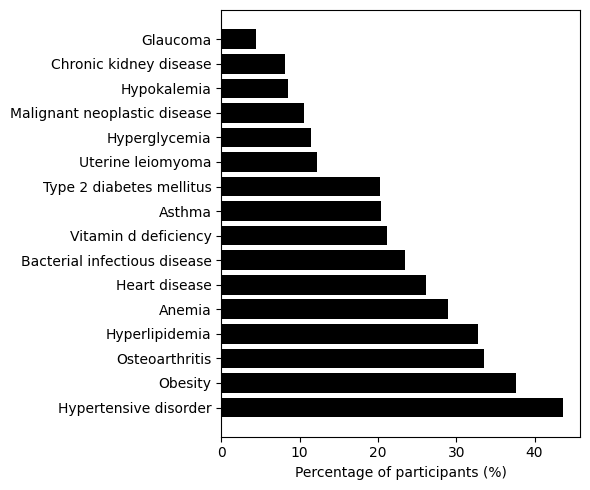

In [15]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Load files
hierarchy_df = pd.read_csv("concept_hierarchy_mapping.tsv", sep="\t")
condition_df = pd.read_csv("AoU_condition_with_details.csv")

total_samples = 1027

# Disease list
diseases_of_interest = [
    "Hypertensive disorder",
    "type 2 diabetes mellitus",
    "chronic kidney disease",
    "obesity",
    "Hypokalemia",
    "hyperglycemia",
    "hyperlipidemia",
    "glaucoma",
    "uterine leiomyoma",
    "osteoarthritis",
    "asthma",
    "obstructive sleep apnea",
    "anemia",
    "malignant neoplastic disease",
    "vitamin d deficiency",
    "heart disease",
    "bacterial infectious disease"
]
diseases_of_interest = [d.lower() for d in diseases_of_interest]

ancestor_to_descendants = defaultdict(set)
for _, row in hierarchy_df.iterrows():
    ancestor_name = str(row["ancestor_name"]).strip().lower()
    descendant_id = int(row["descendant_concept_id"])
    descendant_name = str(row["descendant_name"]).strip()
    ancestor_to_descendants[ancestor_name].add((descendant_id, descendant_name))
    
concept_to_person_ids = defaultdict(set)
for _, row in condition_df.iterrows():
    cid = int(row["concept_id"])
    pid = row["person_id"]
    concept_to_person_ids[cid].add(pid)
    
output_rows = []
plot_data = []

for disease in diseases_of_interest:
    related_concepts = ancestor_to_descendants.get(disease, set())
    if not related_concepts:
        continue
    concept_ids = {cid for cid, _ in related_concepts}
    concept_names = sorted({cname for _, cname in related_concepts})

    all_matched_pids = set()
    for cid in concept_ids:
        all_matched_pids.update(concept_to_person_ids.get(cid, set()))

    if not all_matched_pids:
        continue

    n_individuals = len(all_matched_pids)
    percentage = (n_individuals / total_samples) * 100
    related_names_str = ":,:".join(concept_names)

    output_rows.append(f"{disease}\t{n_individuals}\t{related_names_str}")
    plot_data.append((disease.capitalize(), percentage))
    

plot_df = pd.DataFrame(plot_data, columns=["Disease", "Percentage"])
plot_df = plot_df.sort_values(by="Percentage", ascending=False)

plt.figure(figsize=(6,5))
plt.barh(plot_df["Disease"], plot_df["Percentage"], color="black")
plt.xlabel("Percentage of participants (%)")

plt.tight_layout()
plt.savefig("Enriched_diseases.png", dpi=600)

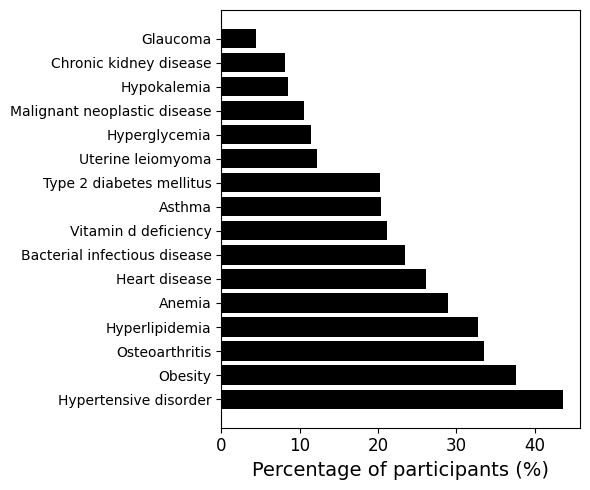

In [38]:
plot_df = pd.DataFrame(plot_data, columns=["Disease", "Percentage"])
plot_df = plot_df.sort_values(by="Percentage", ascending=False)

plt.figure(figsize=(6,5))
plt.barh(plot_df["Disease"], plot_df["Percentage"], color="black")
plt.xlabel("Percentage of participants (%)", fontsize=14)

plt.xticks(fontsize=12)

plt.tight_layout()
plt.savefig("Enriched_diseases.pdf")

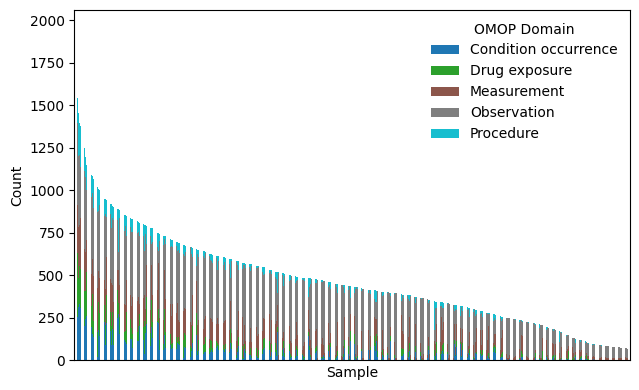

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("AoU_LR_samples_all_domains.csv")
counts = df.groupby(['person_id', 'source'])['concept_id'].nunique().unstack(fill_value=0)

counts['total'] = counts.sum(axis=1)
counts_sorted = counts.sort_values(by='total', ascending=False).drop(columns='total')

long_df = counts_sorted.reset_index().melt(id_vars='person_id', var_name='source', value_name='unique_concept_count')
long_df = long_df[long_df['unique_concept_count'] > 0]
long_df.to_csv("unique_concept_counts_per_sample.tsv", sep='\t', index=False)

domain_labels = {
    "condition": "Condition occurrence",
    "observation": "Observation",
    "drug_exposure": "Drug exposure",
    "measurement": "Measurement",
    "procedure": "Procedure"
}

counts_sorted_renamed = counts_sorted.rename(columns={k: v for k, v in domain_labels.items() if k in counts_sorted.columns})

ax = counts_sorted_renamed.plot(kind='bar', stacked=True, figsize=(6.5, 4), colormap='tab10')
plt.ylabel("Count")
plt.xlabel("Sample")
plt.xticks([], []) 
legend = plt.legend(title="OMOP Domain", frameon=False) 
plt.tight_layout()
                                             
plt.savefig("stacked_bar_unique_concepts_sorted.png", dpi=600, bbox_inches='tight')

In [16]:
import pandas as pd

condition_file = "AoU_condition_with_details.csv"
df_conditions = pd.read_csv(condition_file)
df_conditions = df_conditions[df_conditions["concept_class_id"] == "Disorder"]

hierarchy_file = "concept_hierarchy_mapping.tsv"
df_hierarchy = pd.read_csv(hierarchy_file, sep="\t")

df_hierarchy = df_hierarchy[
    (df_hierarchy["descendant_concept_id"] != df_hierarchy["ancestor_concept_id"]) &
    (df_hierarchy["ancestor_name"].notna()) &
    (df_hierarchy["ancestor_name"].str.strip() != "")
]

ancestor_map = df_hierarchy.groupby("descendant_concept_id")["ancestor_concept_id"] \
    .apply(lambda x: ",".join(map(str, sorted(set(x))))).reset_index()

df_conditions = df_conditions.rename(columns={"concept_id": "descendant_concept_id"})
df_merged = pd.merge(df_conditions, ancestor_map, on="descendant_concept_id", how="left")

df_output = df_merged[["person_id", "descendant_concept_id", "concept_name", "ancestor_concept_id"]]
df_output = df_output.rename(columns={
    "descendant_concept_id": "concept_id",
    "ancestor_concept_id": "ancestor_concept_ids"
})

df_output["ancestor_concept_ids"] = df_output["ancestor_concept_ids"].fillna("")

summary = df_output.groupby(["concept_id", "concept_name", "ancestor_concept_ids"])["person_id"] \
                   .nunique().reset_index(name="num_samples")
summary = summary.sort_values(by="num_samples", ascending=False)
summary.to_csv("disease_summary_suptable.csv", index=False)

In [17]:
!head -n 10 disease_summary_suptable.csv

concept_id,concept_name,ancestor_concept_ids,num_samples
320128,Essential hypertension,"134057,316866,441840,4180628,4274025",435
433736,Obesity,"441840,4274025",347
432867,Hyperlipidemia,"436670,441840,4031814,4170226,4274025,40480457",283
4144111,Gastroesophageal reflux disease without esophagitis,"31610,201891,318800,441840,444089,4000609,4000610,4028071,4038677,4096864,4101212,4117930,4180628,4198525,4201745,4274025,4297887,4302537,4304916,4309188,37311677,37311678,43531058",236
439777,Anemia,"441840,443723,4101673,4274025",223
436070,Vitamin D deficiency,"435227,436658,441840,4029269,4090739,4274025,4276360,4301709,4326403",217
257011,Acute upper respiratory infection,"254068,320136,432250,441840,443883,4006969,4024567,4103320,4112341,4170143,4178545,4180628,4181583,4271450,4274025,4339468",207
4193704,Type 2 diabetes mellitus without complication,"31821,201820,201826,436670,437515,441840,4008576,4130526,4180628,4274025",200
434005,Morbid obesity,"433736,441840,4274025",194


In [20]:
import pandas
import os

# This query represents dataset "Long reads" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_45339929_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) 
            AND cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_lr_whole_genome_variant = 1 ) )"""

dataset_45339929_person_df = pandas.read_gbq(
    dataset_45339929_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_45339929_person_df.head(5)

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1938812,903096,PMI: Skip,2000-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
1,1617794,903096,PMI: Skip,1964-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
2,1222342,903096,PMI: Skip,1994-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
3,1649460,903096,PMI: Skip,1951-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
4,1575575,903096,PMI: Skip,1958-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept


In [21]:
import pandas
import os

# This query represents dataset "Long reads" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_45339929_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  
        AND (
            answer.PERSON_ID IN (SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (SELECT
                    person_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                WHERE
                    has_whole_genome_variant = 1 ) 
                AND cb_search_person.person_id IN (SELECT
                    person_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                WHERE
                    has_lr_whole_genome_variant = 1 ) )
        )"""

dataset_45339929_survey_df = pandas.read_gbq(
    dataset_45339929_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_45339929_survey_df.head(5)

Downloading:   0%|          | 0/23227 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,1541134,2020-01-09 19:04:08+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
1,1240852,2020-02-12 12:31:21+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
2,1949421,2019-10-27 01:12:45+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
3,1600466,2020-02-19 02:01:35+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
4,1525260,2019-11-21 22:09:31+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None


In [22]:
import pandas
import os

# This query represents dataset "Long reads" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_45339929_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) 
            AND cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_lr_whole_genome_variant = 1 ) ) 
        AND observation_source_concept_id = 1585250 
        AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_45339929_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_45339929_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_45339929_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1827456,2020-02-26 17:27:32+00:00,021**,16.192630,87.318666,71783.359081,3.705177,15.740995,6.615493,0.296992,2017
1,1117459,2019-12-09 17:28:01+00:00,023**,12.741530,91.435488,81052.994897,2.828384,8.649236,6.690513,0.247603,2017
2,1275021,2020-02-12 16:01:31+00:00,852**,7.859758,91.715470,74084.321643,9.686876,12.378430,11.347596,0.279662,2017
3,1727508,2019-11-06 20:52:26+00:00,302**,16.585410,87.009912,57795.333808,14.037398,15.769610,9.918717,0.351272,2017
4,1000920,2020-02-19 17:01:25+00:00,352**,15.225864,90.811209,61024.188411,10.300264,18.208478,13.866312,0.332554,2017


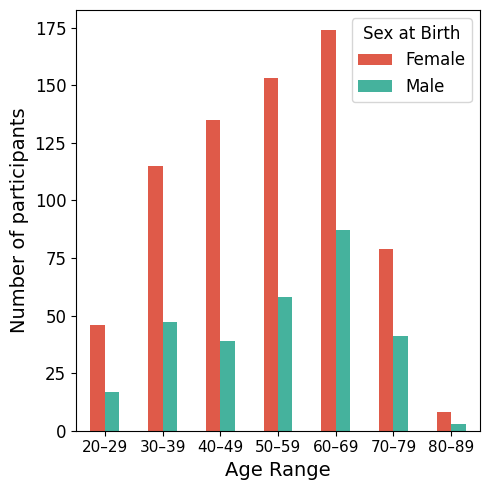

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume your dataframe is already loaded as dataset_45339929_person_df

# Compute age
today = pd.Timestamp.now(tz="UTC")
dataset_45339929_person_df["age"] = (
    today.year - pd.to_datetime(dataset_45339929_person_df["date_of_birth"]).dt.year
)

# Optional: Clean up sex_at_birth
df = dataset_45339929_person_df.copy()
df = df[df["sex_at_birth"].isin(["Male", "Female"])]
df = df[df["age"] >= 20]

# Define age bins
bins = range(20, 100, 10)
df["age_bin"] = pd.cut(df["age"], bins=bins)

# Group by age_bin and sex_at_birth
grouped = df.groupby(["age_bin", "sex_at_birth"]).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))  # 1:1 aspect ratio

grouped.plot(kind="bar", stacked=False, color=["#DF5A49", "#45B29D"], ax=ax)

# Increase font sizes
ax.set_xlabel("Age Range", fontsize=14)
ax.set_ylabel("Number of participants", fontsize=14)
ax.legend(title="Sex at Birth", fontsize=12, title_fontsize=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=12)

# Custom x-axis labels
#ax.set_xticklabels([f"{int(interval.left)}–{int(interval.right-1)}" for interval in grouped.index], rotation=45)
ax.set_xticklabels([f"{int(interval.left)}–{int(interval.right-1)}" for interval in grouped.index], rotation=0)

plt.tight_layout()

# Save plot
plt.savefig("Age_Distribution_by_Sex_20plus.pdf")

# Show plot
plt.show()